In [81]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [3]:
#  Images are single-channel with pixel intensity represented by a float value from 0 to 255,
#  the single-channel intensity is the mean value of the original RGB channel intensities.

# X_train.npy: training data numpy array.
# Each row in the array corresponds to an image unrolled to a vector (50 x 37 = 1850 dimension)
X_train = np.load('X_train.npy')
# y_train.npy: labels (0-6) of each data corresponding to the image in the same row in X_train.npy
y_train = np.load('y_train.npy')

# Test data without label
X_test = np.load('X_test.npy')

In [4]:
# Generate testResults.csv
# Run this with y_pred

def saveTestResults(y_pred, filename='testResults.csv'):
    fo = open(filename, 'w')
    fo.write("ImageId,PredictedClass\n")
    for i in range(len(y_pred)):
        if i == len(y_pred) - 1:
            fo.write(str(i) + "," + str(y_pred[i]))
        else:
            fo.write(str(i) + "," + str(y_pred[i]) + "\n")
    fo.close()

In [180]:
# Reduce dimensionality with PCA (i.e. eigenfaces)
all_data = []
for data in y_train:
    if data not in all_data:
        all_data.append(data)
    else:
        continue


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

n_classes = len(all_data)
n_samples = len(X_train)
n_features = len(X_train[0])

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# For PCA ONLY (eigenfaces)
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

# The closer the captured variance is to 100, the better? To increase, increase n_components.
print('PCA captures {:.2f} percent of the variance in the dataset'.format(pca.explained_variance_ratio_.sum() * 100))

eigenfaces = pca.components_.reshape((n_components, 1, n_features))

# Compute LDA of reduced data - Faruq: not working
# To try, uncomment the following lines and comment out the PCA code block above
# pca_n_components = len(X_train) - n_classes
# print("Extracting the top %d eigenfaces from %d faces" % (pca_n_components, X_train.shape[0]))
# t0 = time()
# pca = PCA(n_components=pca_n_components, svd_solver='randomized', whiten=True).fit(X_train)
# print("done in %0.3fs" % (time() - t0))
# pca_X_train = pca.transform(X_train)

# Faruq: When using scikit LDA not necessary to do initial PCA transform
# Simple LDA - Comment the other blocks above and uncomment the line below
# pca = lda = LDA().fit(X_train, y_train)

# print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

print(X_train_pca.shape)

# Split data (75% train, 25% test)
X_test_pca_split, ZX_test_pca_split, y_test_pca_split, Zy_test_pca_split = train_test_split(X_train_pca, y_train, test_size=0.25, random_state=42)

Total dataset size:
n_samples: 966
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.179s
PCA captures 95.68 percent of the variance in the dataset
done in 0.020s
(966, 150)


In [181]:
# GridSearchCV with SVC (One-vs-One)
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'C': [1, 3, 5, 1e1, 5e1, 1e2, 1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1], }
clf = GridSearchCV(estimator=SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid, cv=10)
clf = clf.fit(X_test_pca_split, y_test_pca_split)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Error in")
internal_pred = clf.predict(ZX_test_pca_split)
print(classification_report(Zy_test_pca_split, internal_pred))

print("Predicting people's names on the test set")
t0 = time()
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)
saveTestResults(y_pred, 'testResults_SVCwithBestEstimator_OneVsOne.csv')

Fitting the classifier to the training set
done in 160.483s
Best estimator found by grid search:
SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Error in
             precision    recall  f1-score   support

          0       0.78      0.54      0.64        13
          1       0.85      0.88      0.86        40
          2       0.94      0.62      0.74        26
          3       0.79      0.91      0.85        92
          4       0.76      0.67      0.71        33
          5       0.86      0.55      0.67        11
          6       0.70      0.85      0.77        27

avg / total       0.81      0.80      0.79       242

Predicting people's names on the test set
done in 281.501s
[3 4 6 1 3 2 2 6 1 3 1 3 3 3 4 0 3 1 3 1 3 0 0 3 3 0 4 1 4 3 2 6 3 2 1 6 3
 6 3 6 3 4 3 1 3 3 4 1 3 3 3 3 3 3 4 2 1 3 4 0 6 4 2 

In [ ]:
# GridSearchCV with SVC (One-vs-Rest)
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'C': [1, 3, 5, 1e1, 5e1, 1e2, 1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1], }
clf = GridSearchCV(estimator=SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovr'), param_grid=param_grid, cv=10)
clf = clf.fit(X_test_pca_split, y_test_pca_split)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Error in")
internal_pred = clf.predict(ZX_test_pca_split)
print(classification_report(Zy_test_pca_split, internal_pred))

print("Predicting people's names on the test set")
t0 = time()
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)
saveTestResults(y_pred, 'testResults_SVCwithBestEstimator_OneVsRest.csv')

In [178]:
# MLP / Neural Network
print("Fitting the classifier to the training set")
t0 = time()

clf = MLPClassifier(solver='lbfgs', alpha=0.00001, hidden_layer_sizes=(1000), max_iter=2000, early_stopping=True, random_state=1)
clf = clf.fit(X_test_pca_split, y_test_pca_split)
print(clf)
print("done in %0.3fs" % (time() - t0))

print("Error in")
internal_pred = clf.predict(ZX_test_pca_split)
print(classification_report(Zy_test_pca_split, internal_pred))

print("Predicting people's names on the test set")
t0 = time()
# clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)
saveTestResults(y_pred, 'testResults_MLP.csv')

Fitting the classifier to the training set
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
done in 1.224s
Error in
             precision    recall  f1-score   support

          0       0.83      0.38      0.53        13
          1       0.67      0.78      0.72        40
          2       0.90      0.35      0.50        26
          3       0.70      0.97      0.81        92
          4       0.62      0.39      0.48        33
          5       1.00      0.55      0.71        11
          6       0.68      0.63      0.65        27

avg / total       0.72      0.70      0.68       242

Predicting people's name

In [120]:
### DT with Adaboost
print("Fitting the classifier to the training set")
t0 = time()

print("Performing with Adaboost")
clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=300)
clf = clf.fit(X_test_pca_split, y_test_pca_split)

# scores = cross_val_score(clf, X_train_pca, y_train)
# print("Mean scores:", scores.mean())

print("Error in")
internal_pred = clf.predict(ZX_test_pca_split)
print(classification_report(Zy_test_pca_split, internal_pred))

print("Predicting people's names on the test set")
t0 = time()
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)
saveTestResults(y_pred, 'testResults_DTwithAdaboost.csv')

Fitting the classifier to the training set
Performing with Adaboost
Error in
             precision    recall  f1-score   support

          0       0.14      0.15      0.15        13
          1       0.33      0.42      0.37        40
          2       0.39      0.27      0.32        26
          3       0.44      0.48      0.46        92
          4       0.42      0.15      0.22        33
          5       0.12      0.27      0.17        11
          6       0.21      0.19      0.20        27

avg / total       0.36      0.34      0.34       242

Predicting people's names on the test set
done in 0.355s
[3 6 3 6 3 2 0 3 3 4 3 1 2 6 3 2 1 3 3 3 3 1 3 5 3 3 3 6 3 3 3 1 1 3 0 3 6
 3 3 3 2 4 1 3 5 1 2 3 3 4 1 5 4 6 6 1 6 3 2 3 4 3 3 3 2 3 1 3 3 1 3 1 3 4
 3 3 2 1 1 6 1 3 1 6 1 2 3 3 3 3 6 1 3 3 3 2 3 1 0 1 3 3 6 3 1 0 3 6 2 5 3
 2 3 5 3 3 1 1 3 4 2 3 4 5 6 2 5 3 3 3 5 1 1 3 0 6 1 3 3 2 6 6 3 3 5 1 3 3
 3 1 3 3 3 4 1 3 3 3 3 6 1 3 3 3 3 3 6 1 3 0 5 3 3 3 1 1 4 3 0 1 1 3 1 4 1
 6 3 6 1 3 

In [58]:
# Linear SVC with Adaboost
print("Fitting the classifier to the training set")
t0 = time()

print("Performing with Adaboost")
clf = AdaBoostClassifier(SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.005, probability=True), n_estimators=300, algorithm='SAMME')
clf = clf.fit(X_test_pca_split, y_test_pca_split)

print("Error in")
internal_pred = clf.predict(ZX_test_pca_split)
print(classification_report(Zy_test_pca_split, internal_pred))

print("Predicting people's names on the test set")
t0 = time()
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)
saveTestResults(y_pred, 'testResults_LinearSVCwithAdaboost.csv')

Fitting the classifier to the training set
Performing with Adaboost
Error in
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00        40
          2       1.00      1.00      1.00        26
          3       1.00      1.00      1.00        92
          4       1.00      1.00      1.00        33
          5       1.00      1.00      1.00        11
          6       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00       242

Predicting people's names on the test set
done in 0.017s
[5 5 5 1 3 2 6 3 6 1 1 2 3 3 5 1 5 1 3 1 3 0 3 2 3 0 4 1 4 1 6 6 3 2 6 3 3
 6 3 6 3 6 3 1 3 3 1 3 3 3 3 6 3 6 4 3 1 0 4 0 6 4 3 0 4 3 3 3 3 3 3 3 6 6
 3 4 2 3 3 3 3 3 6 3 2 6 0 1 2 1 0 4 1 3 1 3 3 6 1 3 3 6 3 3 5 4 2 2 2 3 3
 3 0 5 3 2 6 5 3 2 2 0 5 3 6 3 5 1 2 3 4 4 3 1 2 1 6 2 3 3 1 6 0 5 5 5 6 2
 3 3 3 4 2 3 6 3 6 0 3 5 1 3 4 5 5 4 6 5 3 0 3 3 4 3 5 1 5 3 3 3 0 3 1 4 1
 6 1 1 3 5 

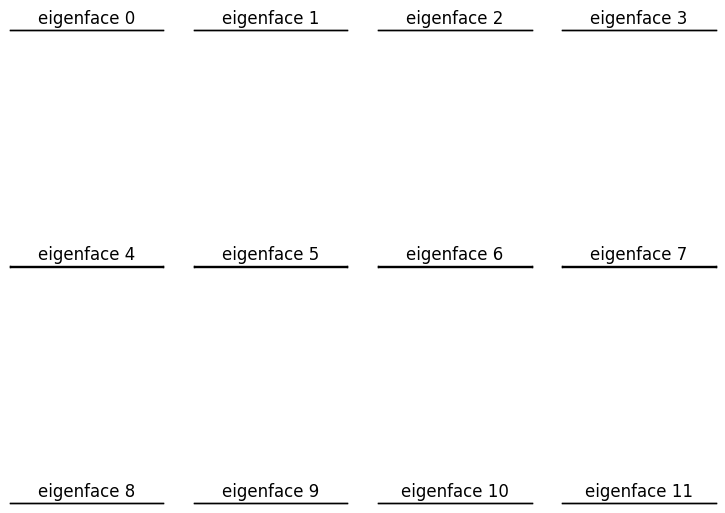

In [77]:
# Util to plot eigenfaces

# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
#
# plot the result of the prediction on a portion of the test set

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 1, n_features)

plt.show()